In [1]:
import h5py
import numpy as np
import pandas as pd
import os,sys,glob
import copy
import time
import xarray as xr
import pickle

import rs_drift.drift as trj

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

sys.path.insert(0, "/users/staff/uvoggenberger/uvpy/rasotools-master/")
import rasotools

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

import ray
# ray.init(num_cpus=80)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

2024-01-29 11:34:14,101	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
inputfile = '/mnt/scratch/scratch/federico/MERGED_YEARLY_06DEC_FULLDATABASE/0-20001-0-11035/0-20001-0-11035_1987_CEUAS_merged_v3.nc'

year = 1987
dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

df_dict = {}
df_dict_w = {}
df_dict_h = {}
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]

with h5py.File(inputfile, 'r') as file:
    rts = file['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    t_idx = file['recordindex'][idx]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]

    p_mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
    v_mask = file['observations_table']['observed_variable'][t_idx[0]:t_idx[-1]]
    mask_t = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [126]))
    mask_wd = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [106]))
    mask_ws = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [107]))
    mask_rh = np.logical_and(np.isin(p_mask,plevs), np.isin(v_mask, [138]))
    t_len = len(mask_t[mask_t == True])

    # wind data
    df_dict_w['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['date_time'] = seconds_to_datetime(df_dict_w['date_time'])
    df_dict_w['wd'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_wd])
    df_dict_w['ws'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_ws])

    df_dict_w['u'] = - np.abs(df_dict_w['ws']) * np.sin(np.radians(df_dict_w['wd']))
    df_dict_w['v'] = - np.abs(df_dict_w['ws']) * np.cos(np.radians(df_dict_w['wd']))

    # humidity data
    df_dict_h['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_rh])
    df_dict_h['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_rh])
    df_dict_h['date_time'] = seconds_to_datetime(df_dict_h['date_time'])
    df_dict_h['rh'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_rh])

    #temperature data
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df_dict['t'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask_t])


    df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask_t])
    repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask_t])
    df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

df_t = pd.DataFrame.from_dict(df_dict)
df_w = pd.DataFrame.from_dict(df_dict_w)
df_h = pd.DataFrame.from_dict(df_dict_h)

df = pd.merge(df_t, df_w[['z_coordinate', 'date_time', 'u', 'v']], on=['z_coordinate', 'date_time'], how='inner')
df = pd.merge(df, df_h[['z_coordinate', 'date_time', 'rh']], on=['z_coordinate', 'date_time'], how='inner')
df['q'] = rasotools.met.humidity.vap2sh(rasotools.met.humidity.rh2vap(df.rh, df.t), df.z_coordinate)

lat_disp, lon_disp, sec_disp = np.array([np.nan]*len(df)),np.array([np.nan]*len(df)),np.array([np.nan]*len(df))

for rid in df.report_id.drop_duplicates():
    df_j = df[df.report_id == rid].copy()

    df_j_cleanded = df_j.sort_values(by='z_coordinate', ascending=False).dropna(subset=['t', 'u', 'v'])
    if len(df_j_cleanded) > 3:

        idx =  df_j_cleanded.index.values
        lat_i, lon_i, sec_i = trj.trajectory(df_j_cleanded.latitude.iloc[0], 
                                                df_j_cleanded.longitude.iloc[0], 
                                                df_j_cleanded.u.values, 
                                                df_j_cleanded.v.values, 
                                                df_j_cleanded.z_coordinate.values, 
                                                df_j_cleanded.t.values
                                            )
        lat_disp[idx] = lat_i
        lon_disp[idx] = lon_i
        sec_disp[idx] = sec_i
df['latitude_displacement'] = lat_disp
df['longitude_displacement'] = lon_disp
df['time_displacement'] = sec_disp



In [4]:
df

,z_coordinate,date_time,t,latitude,longitude,report_id,u,v,rh,q,latitude_displacement,longitude_displacement,time_displacement
0,10000.0,1987-01-01 00:00:00,213.500000,48.25,16.370001,19870000000000000000,16.454483,-9.499998,0.296723,0.000038,-0.443947,1.011463,3046.759855
1,15000.0,1987-01-01 00:00:00,217.500000,48.25,16.370001,19870000000000000000,25.114738,-14.499997,0.312934,0.000043,-0.388653,0.869377,2535.248422
2,20000.0,1987-01-01 00:00:00,220.699997,48.25,16.370001,19870000000000000000,24.513426,-20.569201,0.325731,0.000049,-0.330397,0.746872,2166.256229
3,25000.0,1987-01-01 00:00:00,221.100006,48.25,16.370001,19870000000000000000,31.819811,-31.819799,0.327319,0.000041,-0.262363,0.637980,1877.686219
4,30000.0,1987-01-01 00:00:00,222.699997,48.25,16.370001,19870000000000000000,32.526917,-32.526905,0.172757,0.000022,-0.193785,0.535758,1640.841021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6078,40000.0,1987-12-30 12:00:00,243.100006,48.25,16.370001,19870000000000001456,23.492315,-8.550502,0.299284,0.000237,-0.112764,0.350939,1295.473550
6079,50000.0,1987-12-30 12:00:00,254.300003,48.25,16.370001,19870000000000001456,18.186535,-10.499998,0.871294,0.001504,-0.084902,0.259938,970.643216
6080,70000.0,1987-12-30 12:00:00,271.899994,48.25,16.370001,19870000000000001456,19.052559,-10.999998,0.636553,0.003162,-0.034745,0.130139,452.590551
6081,85000.0,1987-12-30 12:00:00,279.399994,48.25,16.370001,19870000000000001456,22.552624,-8.208482,0.834155,0.005829,-0.007651,0.042394,139.296352


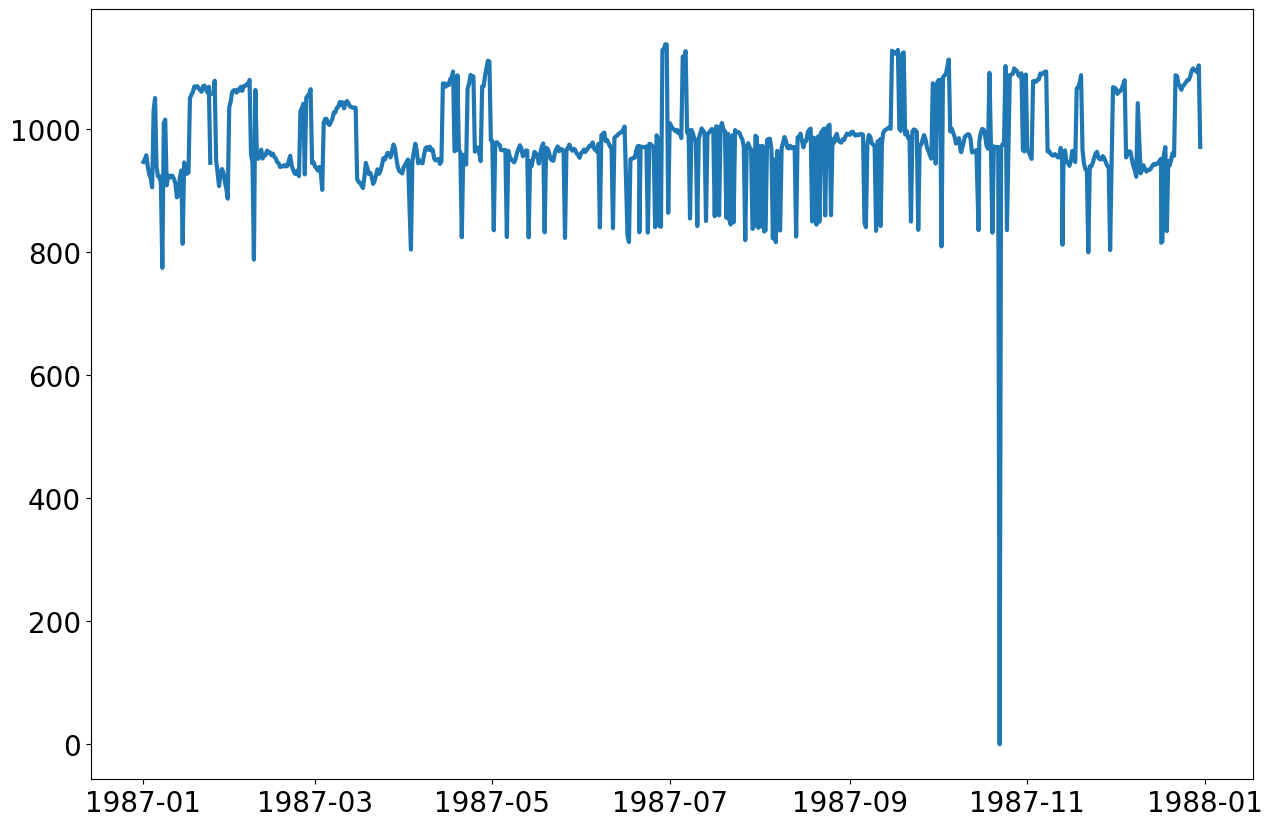

In [5]:
df_sel = df[df.z_coordinate == 50000]
fig, ax = maplt.subplots(1, figsize = (15,10))
maplt.plot(df_sel.date_time, df_sel.time_displacement)

In [2]:
file_list = []
for i in glob.glob('/scratch/das/federico/COP2_HARVEST_JAN2023/igra2/*.nc')[:]:
    file_list.append(i.split('-data')[-2][-5:])
    # print(sid)

In [3]:
len(file_list)

2780

In [4]:
len(np.unique(file_list))

2779

In [5]:
var = 'air temperature'
year = 2000
save_dict = {'eastward windspeed':'u', 'northward windspeed':'v', 'air temperature':'temperature', 'specific humidity':'q'}
units_dict = {'eastward windspeed':'m/s', 'northward windspeed':'m/s', 'air temperature':'K', 'specific humidity':'1'}
stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
diff = True
show_date = False

with open('/users/staff/uvoggenberger/scratch/displacement_data/igra/world/era5_source_bgcheck/era5source_bgcheck_era5_'+save_dict[var]+'_fc_'+str(year)+'_rmse_data.p', 'rb') as file: 
    results = pickle.load(file)

rmse_sum_shbase_sonde, rmse_sum_shdisp_sonde, rms_sum_shbase, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase = copy.deepcopy(results[0])
for i in results[1:]:
    for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
        rmse_sum_shbase_sonde[k]  = rmse_sum_shbase_sonde[k] + i[0][k]
        rmse_sum_shdisp_sonde[k] = rmse_sum_shdisp_sonde[k] + i[1][k]
        rms_sum_shbase[k] = rms_sum_shbase[k] + i[2][k]
        rms_sum_sonde[k] = rms_sum_sonde[k] + i[3][k]
        rms_sum_shdisp[k] =  rms_sum_shdisp[k] + i[4][k]
        rms_sum_dispminusbase[k] = rms_sum_dispminusbase[k] + i[5][k]

print('valid ascents: ', len(rms_sum_shdisp[50000]))
t0 = time.time()
rmse_shbase_sonde=[]
rmse_shdisp_sonde=[]

rms_shbase=[]
rms_sonde=[]
rms_shdisp=[]
rms_dispmbase=[]

for i in range(len(stdplevs)):
    # print(i, ' Pa')
    # testdata = np.array(rms_sum_shdisp[stdplevs[i]])
    # print('valid ascents: ', len(testdata[~ np.isnan(testdata)]))
    # print()

    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    if show_date:    
        print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    if show_date:
        print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
    rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
    if show_date:
        print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


print('')

fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
ax1 = ax[0]
ax2 = ax[1] 
if var != 'specific humidity':
    ax1.set_yscale('log')
    ax2.set_yscale('log')
ax2.sharey(ax1)
if var == 'specific humidity':
    ax1.plot(100000*np.array(rmse_shbase_sonde),stdplevs,color='orange', label=r'RMSE vertical $\times 10^{-5}$')
    ax1.plot(100000*np.array(rmse_shdisp_sonde),stdplevs, color='red', label=r'RMSE slanted $\times 10^{-5}$')
else:
    ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE vertical')
    ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE slanted')

ax1_4 = ax1.twiny()
ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
if var == 'specific humidity':
    if diff:
        ax1_4.plot(100000*(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde)),stdplevs,color='purple', label=r'RMSE difference vertical - slanted $\times 10^{-5}$')
        ax1_4.plot(np.array(rms_dispmbase)*100000,stdplevs, color='green', alpha=0.3, ls='--', label=r'RMS vertical - slanted $\times 10^{-5}$')
else:
    if diff:
        ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='RMSE difference slanted - vertical')
        ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='RMS slanted - vertical')

ax1_4.legend(loc='upper right', prop={'size':14})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel(var+' RMSE (' +str(units_dict[var]) + ')')
ax1.legend(loc='lower left', prop={'size':14})
ax1.grid()

value_nr = []
for i in rmse_sum_shbase_sonde:
    value_nr.append(len(np.asarray(rmse_sum_shbase_sonde[i])[~np.isnan(rmse_sum_shbase_sonde[i])]))
if var == 'specific humidity':
    ax2.barh(stdplevs, value_nr, 3000, color='g', alpha = 0.4, align='center')
else:
    ax2.barh(stdplevs, value_nr, np.array(stdplevs)/7, color='g', alpha = 0.4, align='center')
ax2.set_xlabel('Observations')
ax2.tick_params(labelleft=False)
ax2.grid()

#         maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations    ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
maplt.title(str(year)+' '+var+' RMSE \n' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
maplt.savefig(str(year)+'_'+save_dict[var]+'_era5_fc_world_rmse_plot_era5_1_log_bgtc.png')
maplt.close()
print('RMSE calculation: ', time.time()-t0)

valid ascents:  375532

RMSE calculation:  2.399285078048706


In [ ]:
'/mnt/scratch/scratch/federico/MERGED_YEARLY_06DEC_FULLDATABASE/0-20001-0-11035/0-20001-0-11035_1987_CEUAS_merged_v3.nc'